# Using *Transfer Learning* to spot the sikh
> Session 8 - Neural net Transfer learning

In [147]:
# Importing necessary packages and libraries from tensorflow 

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [149]:
# Image files need to be processed before they can be used with keras
# The below helper function helps with that

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

Lets now use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note only two classifiers.

## Get dataset

In [241]:
# We use the `ImageDataGenerator` function from keras to generate new images based on our existing ones

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./images/train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1334 images belonging to 2 classes.


In [242]:
# We can check the class categories used by the model.
train_generator.class_indices

{'Not Sikh': 0, 'Sikh': 1}

## Mobilenet plug and play

In [148]:
# Using keras API we can get the mobilenet with a call like below 

mobile = keras.applications.mobilenet.MobileNet()

In [238]:
# We will be using mobilenet as a starting point for our base model 

#Below we import the mobilenet model and discard the last 1000 neuron layer.

base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)

 #we add dense layers so that the model can learn more complex functions and classify for better results.
    
x=Dense(1024,activation='relu')(x)

#dense layer 2

x=Dense(1024,activation='relu')(x)

#dense layer 3

x=Dense(512,activation='relu')(x) 

#final layer with softmax activation

preds=Dense(2,activation='softmax')(x) 

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [239]:
# Using the functional API of keras which you have already seen in the previous sessions 

model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

Lets check the model architecture

We will use pre-trained weights as the model has been trained already on the Imagenet dataset. We ensure all the weights are non-trainable. We will only train the last few dense layers.

In [240]:
# For transfer learning, we need to freeze some layers. Below we freeze the first 10 layers

# Below is how we can freeze layers, if we want to set the first 10 layers of the network to be non-trainable
for layer in model.layers[:10]:
    layer.trainable=False
for layer in model.layers[10:]:
    layer.trainable=True

Now lets load the training data into the ImageDataGenerator. Specify path, and it automatically sends the data for training in batches, simplifying the code.

Compile the model. Now lets train it. Should take less than two minutes on a GTX1070 GPU.

## Training the model

In [243]:
# We now train our model, but first we will compile it with an appropriate loss function and optimizer

model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

# in this step we fit the model, but with the help of the fit_generator

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=12)

  ...
    to  
  ['...']
Train for 41 steps
Epoch 1/12
41/41 [==============================] - 24s 584ms/step - loss: 0.3486 - accuracy: 0.8656
Epoch 2/12
41/41 [==============================] - 22s 538ms/step - loss: 0.1977 - accuracy: 0.9278
Epoch 3/12
41/41 [==============================] - 22s 530ms/step - loss: 0.1187 - accuracy: 0.9585
Epoch 4/12
41/41 [==============================] - 23s 556ms/step - loss: 0.0695 - accuracy: 0.9823
Epoch 5/12
41/41 [==============================] - 22s 532ms/step - loss: 0.0391 - accuracy: 0.9954
Epoch 6/12
41/41 [==============================] - 22s 537ms/step - loss: 0.0215 - accuracy: 0.9992
Epoch 7/12
41/41 [==============================] - 23s 558ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 8/12
41/41 [==============================] - 22s 534ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 9/12
41/41 [==============================] - 22s 534ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 10/12
41/41 [============================

Model is now trained. Now lets test some independent input images to check the predictions.

## Inference on unseen data

In [244]:
# A helper function that takes a standard image and converts it into a tensor that can be used by the model

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [248]:
# We specify the paths of the three images 

img_path1 = './NewSnap1.jpg'
img_path2 = './pavlos.jpeg'
img_path3 = './marwari.jpg'


In [257]:
# Helper function that nicely predicts the class along with the input image
def prediction(img_loc,ax,imgname = ''):
    new_image = load_image(img_loc)
    pred = model.predict(new_image)
    classmap = {v:k for k,v in (train_generator.class_indices).items()}
    plot_img = mpimg.imread(img_loc);
    ax.imshow(plot_img)
    ax.set_title(f'{imgname} \n Prediction: {classmap[pred.argmax(-1)[0]]}',fontsize=18)
    ax.axis('off')

## And scene...

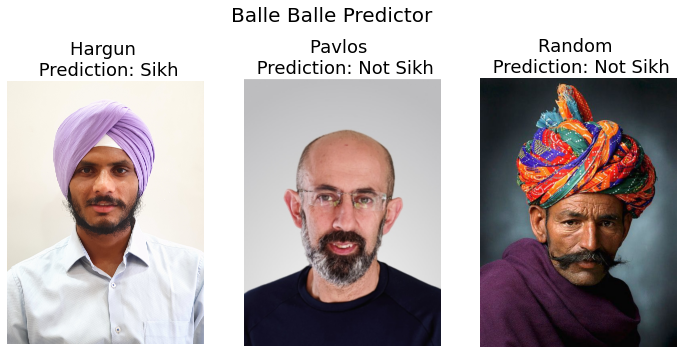

In [258]:
# We now make predictions on three images that were never shown to the model before

fig, axes = plt.subplots(1,3,figsize=(12,6))
prediction(img_path1,axes[0],'Hargun')
prediction(img_path2,axes[1],'Pavlos')
prediction(img_path3,axes[2],'Random')
fig.suptitle('Balle Balle Predictor',fontsize=20);